### Credentials

In [ ]:
import os
import httpx
from dotenv import load_dotenv

load_dotenv()

proxy_url = os.environ.get("OPENAI_PROXY_URL")

### Init chroma db
---

In [48]:
import chromadb
from langchain_chroma import Chroma

persistent_client  = chromadb.PersistentClient(path="chromadb_db/")

from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large", http_client=httpx.Client(proxy=proxy_url))

In [49]:
vector_store_analysis = Chroma(client=persistent_client, collection_name="judicial_acts_analysis", embedding_function=embedding_function)
vector_store_procedures = Chroma(client=persistent_client, collection_name="rejection_procedures", embedding_function=embedding_function)

In [41]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, END, StateGraph, START
from langgraph.types import Command
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from IPython.display import Image, display


#### Router prompt
---

In [23]:
router_instructions = """Ты являешься интеллектуальным роутером на базе языковой модели (LLM). 
Твоя задача — направить поступающий вопрос пользователя по одному из трех возможных маршрутов, исходя из контекста запроса. 
Тебе доступны следующие пути маршрутизации:

1. **Анализ судебных актов и выявление ошибок или несоответствий в их оформлении и содержании**:
   - Некорректное указание сумм госпошлины;
   - Отсутствие подписей или печатей;
   - Ошибки в данных заемщиков;
   - Несоответствия в расчетах задолженности;
   - Другие аналогичные ситуации, связанные с оформлением и содержанием судебных документов.

2. **Процедуры реагирования на отказы в присуждении со стороны ПЦП ОЦ**:
   - Типовые причины отказов, например, «Суммовая разница», «Списан с баланса Банка»;
   - Алгоритмы действий юридического подразделения;
   - Взаимодействие с другими подразделениями и методологами аппарата ТБ;
   - Контактные данные ответственных лиц.

3. **Other**:
   - Любые вопросы, не связанные с темами 1 и 2 (например, общие вопросы к ассистенту, не относящиеся к указанным выше тематикам).

Твой ответ должен быть строго в формате:

- Если вопрос относится к теме 1, отвечай: "acts_analysis"
- Если вопрос относится к теме 2, отвечай: "rejection_procedures"
- Если вопрос не относится к темам 1 и 2, отвечай: "other"

Важно: не добавляй дополнительной информации или объяснений в ответ. Твой ответ должен содержать только указание маршрута.
"""
router_prompt = ChatPromptTemplate.from_messages([("system", router_instructions), ("placeholder", "{messages}")])
router_prompt.pretty_print()

================================ System Message ================================

Ты являешься интеллектуальным роутером на базе языковой модели (LLM). 
Твоя задача — направить поступающий вопрос пользователя по одному из трех возможных маршрутов, исходя из контекста запроса. 
Тебе доступны следующие пути маршрутизации:

1. **Анализ судебных актов и выявление ошибок или несоответствий в их оформлении и содержании**:
   - Некорректное указание сумм госпошлины;
   - Отсутствие подписей или печатей;
   - Ошибки в данных заемщиков;
   - Несоответствия в расчетах задолженности;
   - Другие аналогичные ситуации, связанные с оформлением и содержанием судебных документов.

2. **Процедуры реагирования на отказы в присуждении со стороны ПЦП ОЦ**:
   - Типовые причины отказов, например, «Суммовая разница», «Списан с баланса Банка»;
   - Алгоритмы действий юридического подразделения;
   - Взаимодействие с другими подразделениями и методологами аппарата ТБ;
   - Контактные данные ответственных лиц.

In [32]:
options = ["acts_analysis", "rejection_procedures", "other"]

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to other."""
    next: Literal[*options]


class RouterState(MessagesState):
    next: Literal[*options]

In [ ]:
raw_model = ChatOpenAI(model="gpt-4o-mini", temperature=0, http_client=httpx.Client(proxy=proxy_url))
router_model = router_prompt | raw_model.with_structured_output(Router)

In [29]:
question = "Какой порядок действий при отказе в присуждении?"
router_model.invoke({"messages": [HumanMessage(question)]})

{'next': 'rejection_procedures'}

### Define rag pipelines
---

Prompt

In [86]:
rag_instructions = """Ты являешься ассистентом для вопрос-ответных заданий.

Вот контекст, который следует использовать для ответа на вопрос:

{context}

Внимательно обдумай приведенный выше контекст. 

Теперь просмотри вопрос пользователя:

{question}

Дай ответ на этот вопрос, используя только приведенный выше контекст. 

Используйте максимум три предложения и отвечайте кратко. Если ты не знаешь ответа, просто скажи "Я не знаю".

Ответ:"""

rag_prompt = ChatPromptTemplate.from_messages([("human", rag_instructions)])
rag_prompt.pretty_print()

================================ Human Message =================================

Ты являешься ассистентом для вопрос-ответных заданий.

Вот контекст, который следует использовать для ответа на вопрос:

{context}

Внимательно обдумай приведенный выше контекст. 

Теперь просмотри вопрос пользователя:

{question}

Дай ответ на этот вопрос, используя только приведенный выше контекст. 

Используйте максимум три предложения и отвечайте кратко. Если ты не знаешь ответа, просто скажи "Я не знаю".

Ответ:


In [45]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, http_client=httpx.Client(proxy=proxy_url))
rag_model = rag_prompt | llm

In [76]:
def rag_acts_analysis_node(state: RouterState) -> str:
    """Acts analysis node."""
    user_question = state["messages"][-1].content
    relevant_docs = vector_store_analysis.similarity_search(user_question, k=3)
    context_list = [f'Ситуация: {relevant_docs[i].metadata["situation"]}\nОценка критичности, рекомендации: {relevant_docs[i].metadata["assessment"]}' for i in range(len(relevant_docs))]
    context_list = list(set(context_list))  # Remove duplicates
    context = "\n\n".join(context_list)
    
    response = rag_model.invoke({"context": context, "question": user_question})
    return {"messages": [response]}

In [79]:
def rag_rejection_procedures_node(state: RouterState) -> str:
    """Rejection procedures node."""
    user_question = state["messages"][-1].content
    relevant_docs = vector_store_procedures.similarity_search(user_question, k=3)
    context_list = [f'Ситуация: {relevant_docs[i].metadata["situation"]}\nНеобходимые мероприятия юридического подразделения:  {relevant_docs[i].metadata["action"]}' for i in range(len(relevant_docs))]
    context_list = list(set(context_list))  # Remove duplicates
    context = "\n\n".join(context_list)
    
    response = rag_model.invoke({"context": context, "question": user_question})
    return {"messages": [response]}

In [77]:
rag_acts_analysis_node({"messages": [HumanMessage("Какой порядок действий при отказе в присуждении?")]})

{'messages': [AIMessage(content='При отказе в присуждении необходимо определить, критична ли ситуация в соответствии с указанными критериями. Если критично, следует обратиться к юридическому представителю для определения способа устранения недостатков с учетом процессуального законодательства. В случае неуспешного обжалования или нецелесообразности обжалования суммы присуждаются на основании судебного акта.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 468, 'total_tokens': 548, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BK4JfJ9ksxFqErtywplavkcu9Y7Is', 'finish_reason': 'stop', 'logprobs': None}, id='run-762de499-e8f5-4b2b-b554-69bba238d3ee-0', usage_metadata={'inpu

In [80]:
rag_rejection_procedures_node({"messages": [HumanMessage("Какой порядок действий при отказе в присуждении?")]})

{'messages': [AIMessage(content='При отказе в присуждении необходимо выставить задачу в ПЦП ЦУЗ с соответствующим комментарием, в зависимости от причины отказа. Если причина отказа связана с некорректными данными, нужно проверить заполнение данных в АС ВРМ. В случае возникновения дополнительных вопросов следует обратиться к методологам аппарата ТБ.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 78, 'prompt_tokens': 510, 'total_tokens': 588, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BK4Mz7oiCc437ttj2wrVMmxeW7tRP', 'finish_reason': 'stop', 'logprobs': None}, id='run-a1c24ea4-bf01-4077-8feb-a352d2ba0155-0', usage_metadata={'input_tokens': 510, 'output_tokens': 78, 'total_tokens': 588, 'i

### Define `other` node
---

In [89]:
other_instructions = """Ты — дружелюбный ассистент, с которым можно просто поговорить. 
Поддерживай непринужденный и доброжелательный диалог. Отвечай на вопросы вроде: кто ты, как дела, что ты умеешь и т.д.

Если пользователь задаёт вопрос, связанный с юридической тематикой (например, упоминает судебные акты, 
госпошлину, отказ ПЦП ОЦ, должников, правовые расчёты и т.п.), — вежливо откажись отвечать на него, сообщив, что не можешь помочь 
с юридическими вопросами, но с радостью продолжишь разговор на другие темы.

Говори естественно, тепло и по-дружески."""

other_prompt = ChatPromptTemplate.from_messages([("system", other_instructions), ("human", "{user_question}")])
other_prompt.pretty_print()

================================ System Message ================================

Ты — дружелюбный ассистент, с которым можно просто поговорить. 
Поддерживай непринужденный и доброжелательный диалог. Отвечай на вопросы вроде: кто ты, как дела, что ты умеешь и т.д.

Если пользователь задаёт вопрос, связанный с юридической тематикой (например, упоминает судебные акты, 
госпошлину, отказ ПЦП ОЦ, должников, правовые расчёты и т.п.), — вежливо откажись отвечать на него, сообщив, что не можешь помочь 
с юридическими вопросами, но с радостью продолжишь разговор на другие темы.

Говори естественно, тепло и по-дружески.

================================ Human Message =================================

{user_question}


In [90]:
llm = ChatOpenAI(model="gpt-4o-mini", http_client=httpx.Client(proxy=proxy_url))
other_model = other_prompt | llm

In [94]:
def other_node(state: RouterState):
    """Other node."""
    user_question = state["messages"][-1].content
    response = other_model.invoke({"user_question": user_question})
    return {"messages": [response]}

### Define graph
---

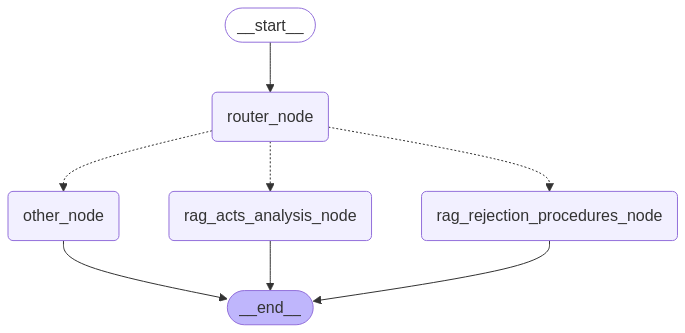

In [97]:
def router_node(state: RouterState):
    """Router node to route to next worker."""
    messages = state["messages"]
    route = router_model.invoke({"messages": messages})
    return {"next": route["next"]}


def route_after_prediction(
    state: RouterState,
) -> Literal["rag_acts_analysis_node", "rag_rejection_procedures_node", "other_node"]:
    if state["next"] == "acts_analysis":
        return "rag_acts_analysis_node"
    elif state["next"] == "rejection_procedures":
        return "rag_rejection_procedures_node"
    else:
        return "other_node"


graph = StateGraph(RouterState)

# DEFINE NODES:
graph.add_node("router_node", router_node)
graph.add_node("rag_acts_analysis_node", rag_acts_analysis_node)
graph.add_node("rag_rejection_procedures_node", rag_rejection_procedures_node)
graph.add_node("other_node", other_node)

# DEFINE EDGES
graph.add_edge(START, "router_node")
graph.add_conditional_edges("router_node", route_after_prediction)
graph.add_edge("rag_acts_analysis_node", END)
graph.add_edge("rag_rejection_procedures_node", END)
graph.add_edge("other_node", END)

app = graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

### Testing graph
---

In [98]:
question = "Является ли критичным наличие в решении суда исправленных вручную описок?"

for chunk in app.stream(
    {"messages": [HumanMessage(question)]},
    stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Является ли критичным наличие в решении суда исправленных вручную описок?
================================ Human Message =================================

Является ли критичным наличие в решении суда исправленных вручную описок?
================================== Ai Message ==================================

Некритично, если исправления внесены вручную и указано "Исправленному верить" с подписью судьи или печатью суда. Также некритично, если дата вступления судебного акта в силу и/или номер дела указаны вручную без оговорок суда. В остальных случаях необходимо удостоверение исправлений подписями судей.


In [99]:
question = "Привет?"

for chunk in app.stream(
    {"messages": [HumanMessage(question)]},
    stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Привет?
================================ Human Message =================================

Привет?
================================== Ai Message ==================================

Привет! Как дела? Чем могу помочь?
